# Predict both halo mass and Vmax for all subhalos

In [1]:
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('../src')

from data import *
from model import *
from train import *
import random

ROOT = Path("..").resolve()
tng_base_path = f"{ROOT}/illustris_data/TNG50-1/output"

seed = 255
rng = np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [11]:
# predict outputs: log_halo_mass, vmax, both
science_params = dict(
    minimum_log_stellar_mass=7.5,   
    predict_output="both",
)

experiment = science_params["predict_output"]


config_params = dict(
    boxsize=51.7e3,    # box size in comoving kpc/h
    h_reduced=0.704,   # reduced Hubble constant
    snapshot=99,       # z = 0
)

normalization_params = dict(
    minimum_n_star_particles=10., # min star particles to be considered a galaxy
    norm_half_mass_radius=3., 
    norm_velocity=100., # note: use value of 1 if `use_central_galaxy_frame=True`
)

feature_params = dict(
    use_stellarhalfmassradius=False,
    use_velocity=True,
    use_only_positions=False,
    use_central_galaxy_frame=False, # otherwise use center of mass frame
    in_projection=True, # only use projected positions and radial velocity
)

training_params = dict(
    batch_size=256,
    learning_rate=1e-4,
    weight_decay=1e-5,
    n_epochs=300,
    valid_frac=0.15, 
    test_frac=0., 
)

model_params = dict(
    k_nn=100,
    n_layers=1,  
    n_hidden=128,
    n_latent=96,
    n_out=2 if experiment == "both" else 1,
    loop=False
)


print(f'Experiment: predicting {experiment}')
print(f'stellar mass cut: log(M* / Msun) > {science_params["minimum_log_stellar_mass"]:g}')
print(f'Feature params:', feature_params)

Experiment: predicting both
stellar mass cut: log(M* / Msun) > 7.5
Feature params: {'use_stellarhalfmassradius': False, 'use_velocity': True, 'use_only_positions': False, 'use_central_galaxy_frame': False, 'in_projection': True}


In [12]:
# df = load_data(
#     tng_base_path=tng_base_path,
#     snapshot=config_params["snapshot"], # default is 99 -> z=0 
#     use_stellarhalfmassradius=feature_params["use_stellarhalfmassradius"],
#     use_velocity=feature_params["use_velocity"],
#     use_only_positions=feature_params["use_only_positions"],
#     in_projection=feature_params["in_projection"],
#     science_params=science_params
# )

# dataset, n_subhalos = generate_dataset(
#     df,
#     use_velocity=feature_params["use_velocity"],
#     use_only_positions=feature_params["use_only_positions"],
#     in_projection=feature_params["in_projection"],
#     use_stellarhalfmassradius=feature_params["use_stellarhalfmassradius"],
#     science_params=science_params
# )

# torch.save(dataset, f"{ROOT}/results/both/dataset.pth")


In [13]:
dataset = torch.load(f"{ROOT}/results/both/dataset.pth")

node_features = dataset[0].x.shape[1]
n_halos = len(dataset)

print("Number of features:", node_features)
# print("Number of subhalos:", n_subhalos)
print("Number of halos:", n_halos)

Number of features: 4
Number of halos: 537


In [14]:
model = EdgePointGNN(
    node_features=node_features, 
    n_layers=model_params["n_layers"], 
    n_out=model_params["n_out"],
    k_nn=model_params["k_nn"],
    hidden_channels=model_params["n_hidden"],
    latent_channels=model_params["n_latent"],
    loop=model_params["loop"],
    estimate_all_subhalos=True
)

model.to(device)

EdgePointGNN(
  (layers): ModuleList(
    (0): EdgePointLayer()
  )
  (fc): Sequential(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=96, out_features=96, bias=True)
    (4): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=96, out_features=4, bias=True)
  )
)

In [15]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=training_params["learning_rate"], 
    weight_decay=training_params["weight_decay"]
)

In [16]:
train_loader, valid_loader, test_loader = split_datasets(
    dataset,
    rng=rng,
    valid_frac=training_params["valid_frac"],
    test_frac=training_params["test_frac"],
    batch_size=training_params["batch_size"],
)

print("Number of training batches", len(train_loader))
print("Number of valication batches", len(valid_loader))
print("Number of test batches", len(test_loader))

Number of training batches 2
Number of valication batches 1
Number of test batches 0


In [17]:
train_losses = []
valid_losses = []
for epoch in range(training_params["n_epochs"]):
    train_loss = train(train_loader, model, optimizer, device, in_projection=feature_params["in_projection"])
    valid_loss, valid_std, *_ = validate(valid_loader, model, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1: >3d}    train loss: {train_loss: >4.1f}     valid loss: {valid_loss: >4.1f}     average valid std: {np.mean(valid_std): >5.3f}")


Epoch  10    train loss: -1.4     valid loss: -1.0     average valid std: 0.463
Epoch  20    train loss: -2.6     valid loss: -1.8     average valid std: 0.331
Epoch  30    train loss: -3.1     valid loss: -2.1     average valid std: 0.290
Epoch  40    train loss: -3.3     valid loss: -2.1     average valid std: 0.263
Epoch  50    train loss: -3.3     valid loss: -2.1     average valid std: 0.245
Epoch  60    train loss: -3.4     valid loss: -2.2     average valid std: 0.230
Epoch  70    train loss: -3.4     valid loss: -2.2     average valid std: 0.217
Epoch  80    train loss: -3.5     valid loss: -2.2     average valid std: 0.207
Epoch  90    train loss: -3.4     valid loss: -2.2     average valid std: 0.197
Epoch 100    train loss: -3.5     valid loss: -2.2     average valid std: 0.190
Epoch 110    train loss: -3.5     valid loss: -2.2     average valid std: 0.185
Epoch 120    train loss: -3.5     valid loss: -2.2     average valid std: 0.180
Epoch 130    train loss: -3.5     valid 

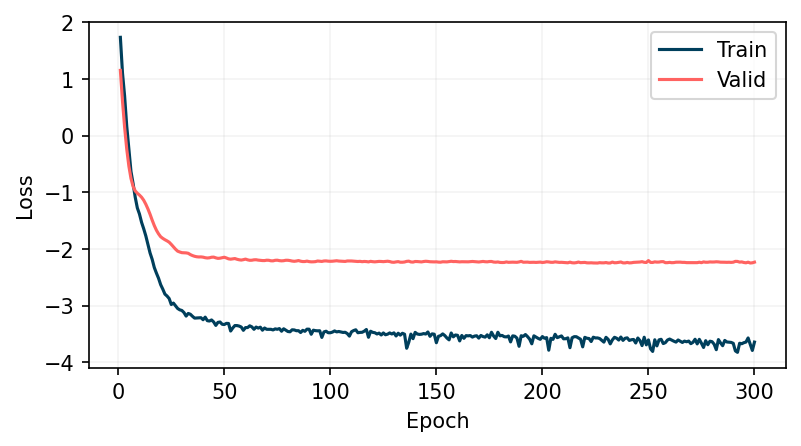

In [18]:
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(1 + np.arange(training_params["n_epochs"]), train_losses, c=c0, label="Train")
plt.plot(1 + np.arange(training_params["n_epochs"]), valid_losses, c=c3, label="Valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.15)

In [19]:
valid_loss, valid_std, p_valid, y_valid, logvar_valid = validate(valid_loader, model, device)

p_Mhalo, p_Vmax = p_valid.reshape(-1, 2).T
y_Mhalo, y_Vmax = y_valid.reshape(-1, 2).T

print(f"Mhalo RMSE: {np.sqrt(np.mean((p_Mhalo.flatten() - y_Mhalo)**2)): >4.3f}")
print(f"Vmax RMSE: {np.sqrt(np.mean((p_Vmax.flatten() - y_Vmax)**2)): >4.3f}")

Mhalo RMSE: 0.806
Vmax RMSE: 0.073


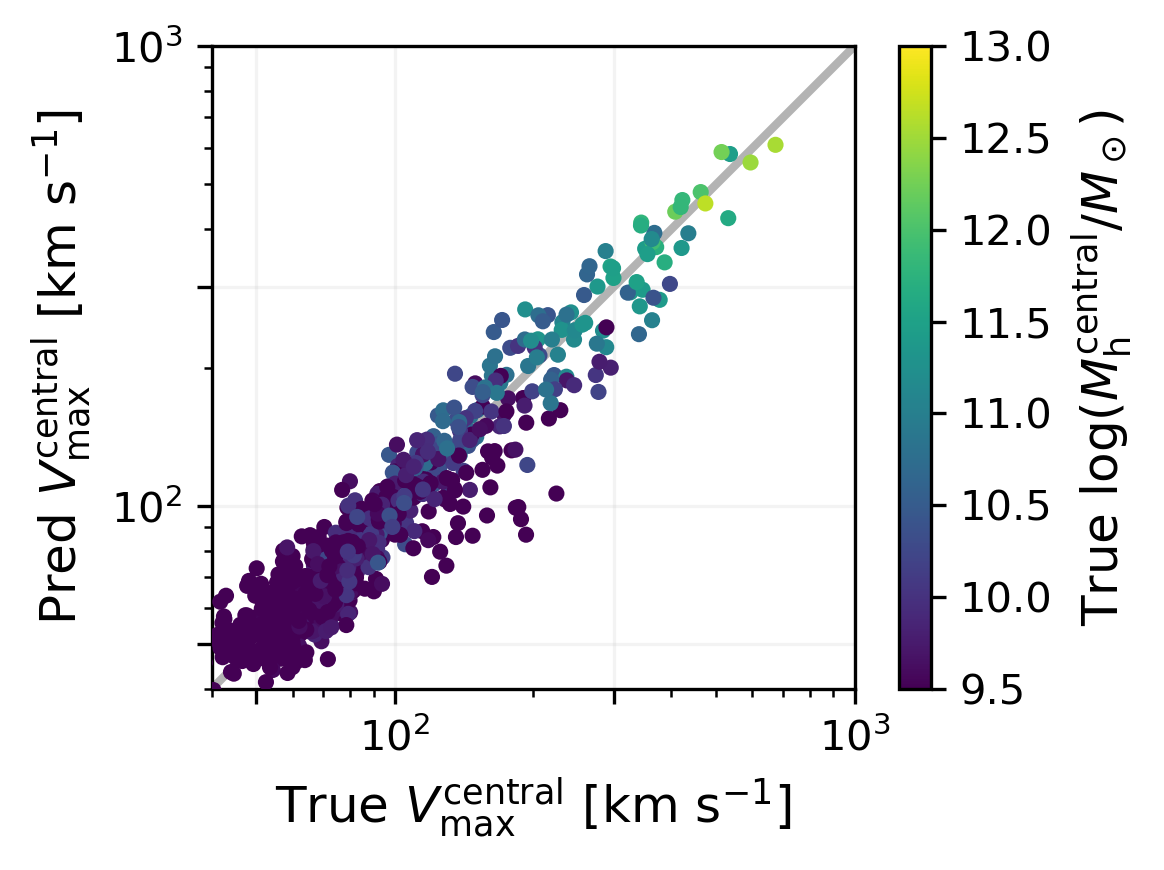

In [20]:
plt.figure(figsize=(4, 3), dpi=300)

h = config_params["h_reduced"]
p = 10**p_Vmax * normalization_params["norm_velocity"]
y = 10**y_Vmax * normalization_params["norm_velocity"]

sc = plt.scatter(y, p, s=15, edgecolors='none', c=y_Mhalo + 10 - config_params["h_reduced"], zorder=3, vmin=9.5, vmax=13.)
cb = plt.colorbar(sc)
cb.set_label("True $\\log(M_{\\rm h}^{\\rm central}/M_\\odot)$", fontsize=12)

plt.xlabel("True $V_{\\rm max}^{\\rm central}$ [km s$^{-1}$]", fontsize=12)
plt.ylabel("Pred $V_{\\rm max}^{\\rm central}$ [km s$^{-1}$]", fontsize=12)
plt.plot([0, 1e4], [0, 1e4], c='0.7', lw=2, zorder=1)
plt.gca().set_aspect("equal")

plt.xlim(40, 1000)
plt.ylim(40, 1000)
plt.xscale('log')
plt.yscale('log')
plt.xticks([50, 100, 300, 1000])
plt.yticks([50, 100, 300, 1000])
plt.tight_layout()
plt.grid(alpha=0.15)

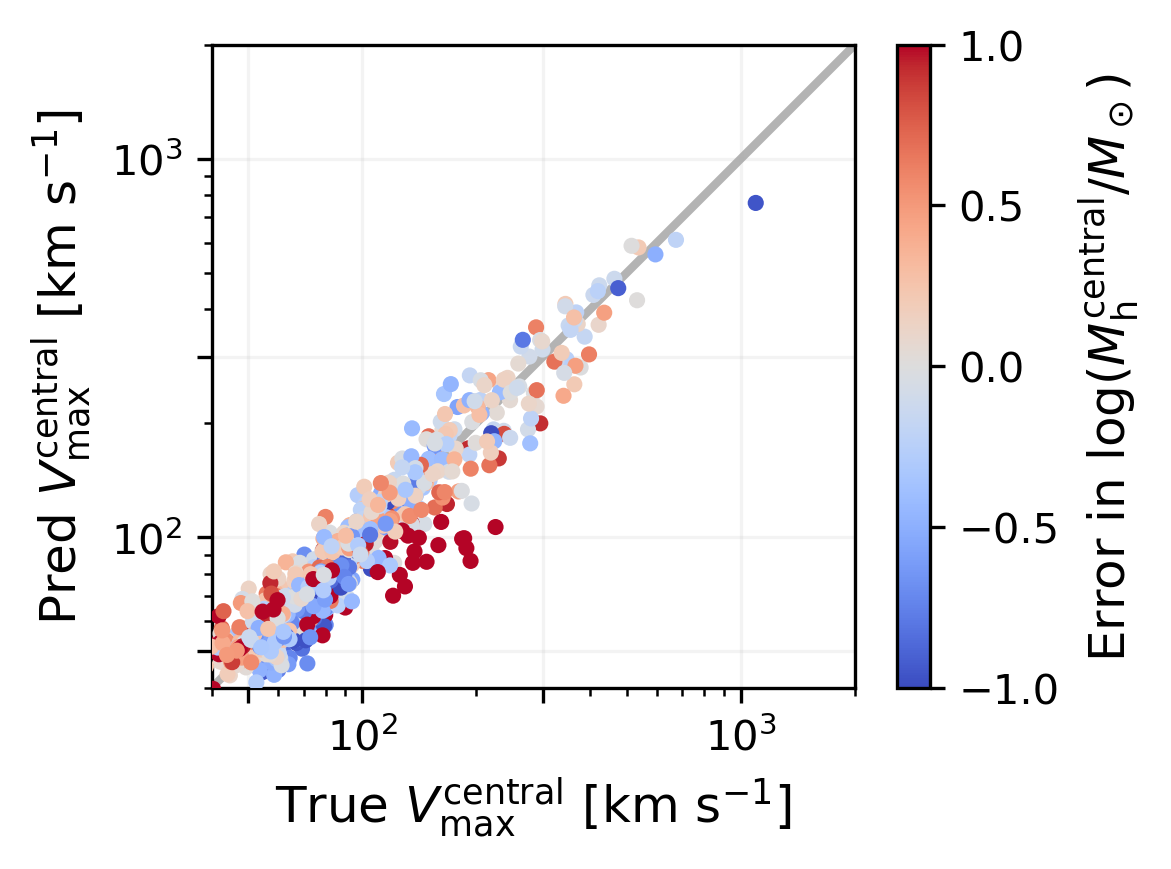

In [21]:
plt.figure(figsize=(4, 3), dpi=300)

h = config_params["h_reduced"]
p = 10**p_Vmax * normalization_params["norm_velocity"]
y = 10**y_Vmax * normalization_params["norm_velocity"]

sc = plt.scatter(y, p, s=15, edgecolors='none', c=p_Mhalo-y_Mhalo, zorder=3, vmin=-1, vmax=1, cmap="coolwarm")
cb = plt.colorbar(sc)
cb.set_label("Error in $\\log(M_{\\rm h}^{\\rm central}/M_\\odot)$", fontsize=12)

plt.xlabel("True $V_{\\rm max}^{\\rm central}$ [km s$^{-1}$]", fontsize=12)
plt.ylabel("Pred $V_{\\rm max}^{\\rm central}$ [km s$^{-1}$]", fontsize=12)
plt.plot([0, 1e4], [0, 1e4], c='0.7', lw=2, zorder=1)
plt.gca().set_aspect("equal")

plt.xlim(40, 2000)
plt.ylim(40, 2000)
plt.xscale('log')
plt.yscale('log')
plt.xticks([50, 100, 300, 1000])
plt.yticks([50, 100, 300, 1000])
plt.tight_layout()
plt.grid(alpha=0.15)

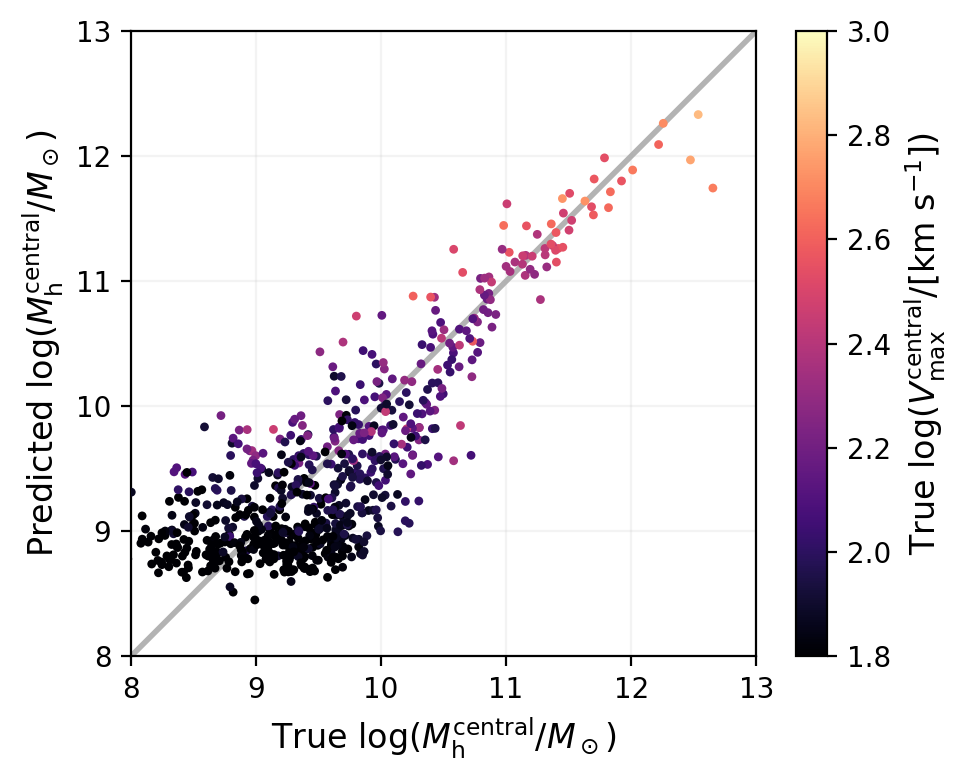

In [22]:
plt.figure(figsize=(5, 4), dpi=200)

p = p_Mhalo + 10 - config_params["h_reduced"]
y = y_Mhalo + 10 - config_params["h_reduced"]

sc = plt.scatter(y, p, s=10, edgecolors='none', c=y_Vmax+2, zorder=3, vmin=1.8, vmax=3.0, cmap="magma")
cb = plt.colorbar(sc)
cb.set_label("True log($V_{\\rm max}^{\\rm central}$/[km s$^{-1}$])", fontsize=12)

plt.xlabel("True $\\log(M_{\\rm h}^{\\rm central}/M_\\odot)$", fontsize=12)
plt.ylabel("Predicted $\\log(M_{\\rm h}^{\\rm central}/M_\\odot)$", fontsize=12)
plt.plot([7.75, 13.25], [7.75, 13.25], c='0.7', lw=2, zorder=1)
plt.gca().set_aspect("equal")

plt.xlim(8, 13)
plt.ylim(8, 13)
plt.xticks([8, 9, 10, 11, 12, 13])
plt.yticks([8, 9, 10, 11, 12, 13])
plt.tight_layout()
plt.grid(alpha=0.15)

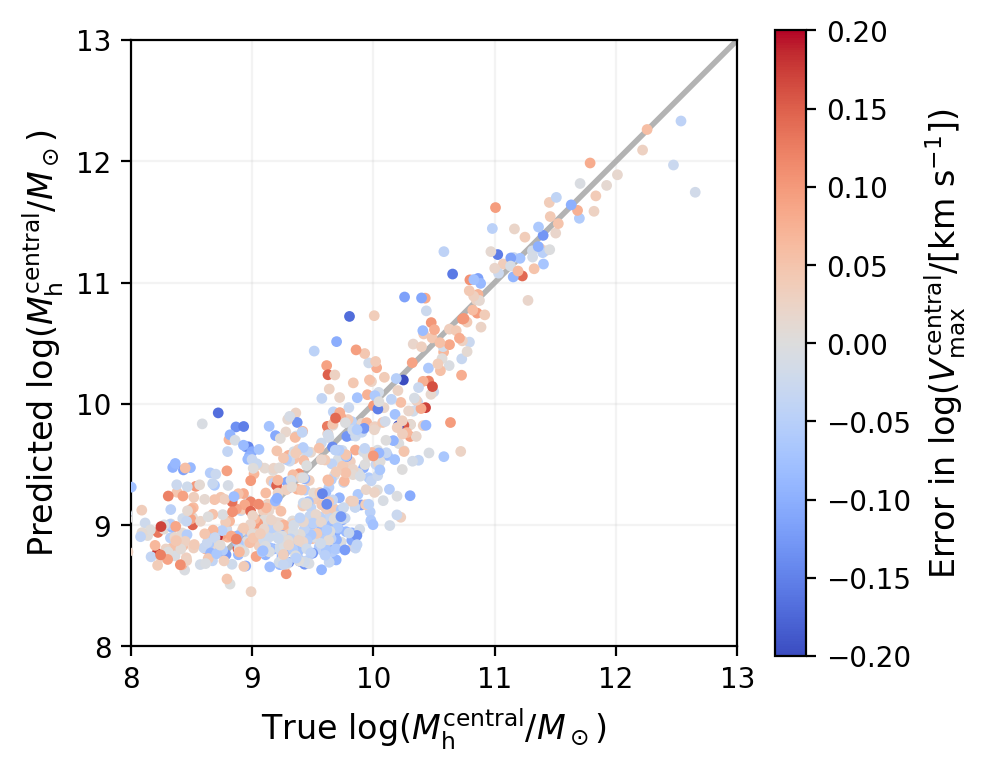

In [23]:
plt.figure(figsize=(5, 4), dpi=200)

p = p_Mhalo + 10 - config_params["h_reduced"]
y = y_Mhalo + 10 - config_params["h_reduced"]

sc = plt.scatter(y, p, s=15, edgecolors='none', c=p_Vmax-y_Vmax, zorder=3, vmin=-0.2, vmax=0.2, cmap="coolwarm")
cb = plt.colorbar(sc)
cb.set_label("Error in log($V_{\\rm max}^{\\rm central}$/[km s$^{-1}$])", fontsize=12)

plt.xlabel("True $\\log(M_{\\rm h}^{\\rm central}/M_\\odot)$", fontsize=12)
plt.ylabel("Predicted $\\log(M_{\\rm h}^{\\rm central}/M_\\odot)$", fontsize=12)
plt.plot([8.75, 13.25], [8.75, 13.25], c='0.7', lw=2, zorder=1)
plt.gca().set_aspect("equal")

plt.xlim(8, 13)
plt.ylim(8, 13)
plt.xticks([8, 9, 10, 11, 12, 13])
plt.yticks([8, 9, 10, 11, 12, 13])
plt.tight_layout()
plt.grid(alpha=0.15)